## load dataset

In [1]:
from PIL import Image
import numpy as np

In [2]:
from datasets import load_dataset

dataset = load_dataset("huggan/selfie2anime", split="train")

Using custom data configuration huggan--selfie2anime-2601eb6cdec450c3
Reusing dataset parquet (/home/ashish.jha/.cache/huggingface/datasets/huggan___parquet/huggan--selfie2anime-2601eb6cdec450c3/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


In [3]:
print(dataset)

Dataset({
    features: ['imageA', 'imageB'],
    num_rows: 3400
})


In [4]:
dataset["imageB"]

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image 

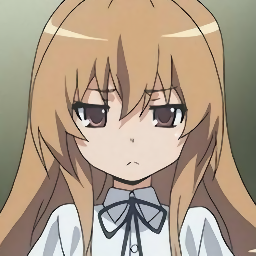

In [5]:
img = dataset["imageB"][0]
img

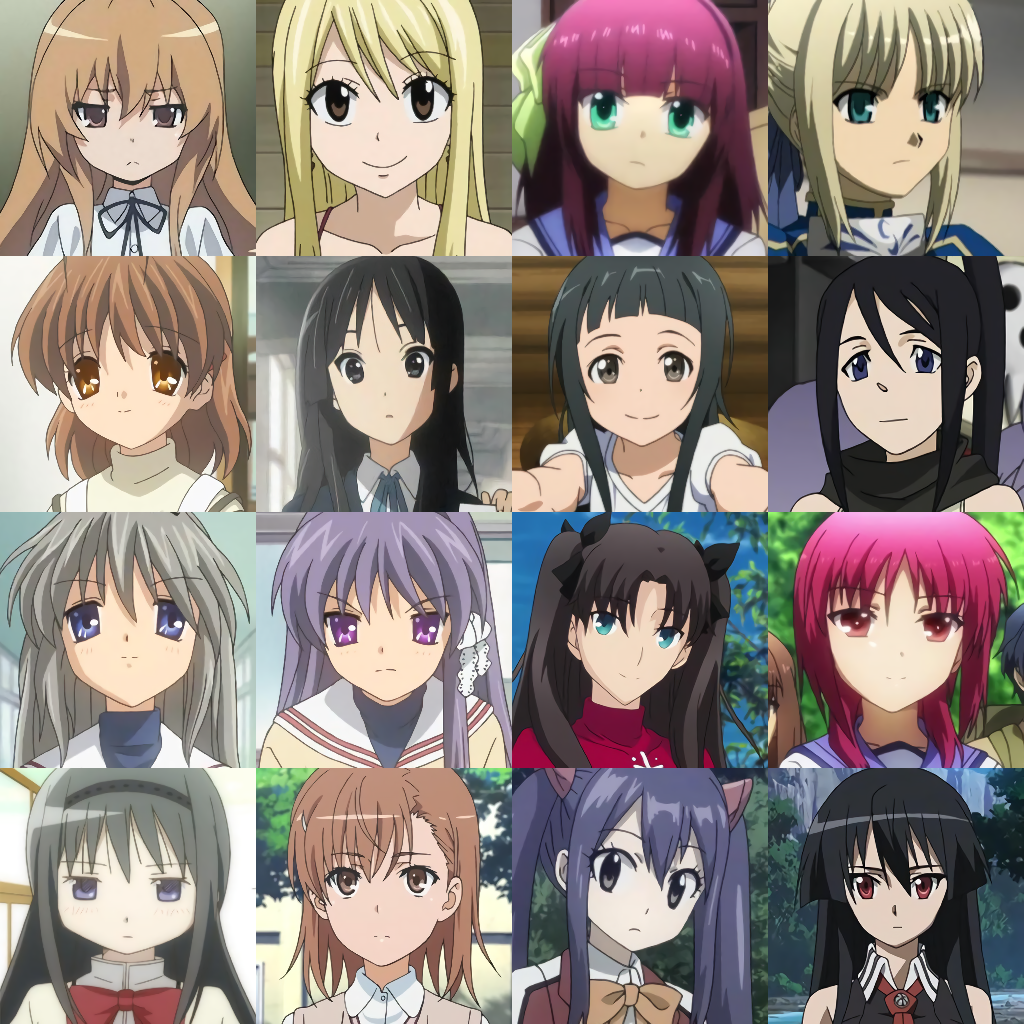

In [6]:
from diffusers.utils import make_image_grid
make_image_grid(dataset["imageB"][:16], rows=4, cols=4)

#### demonstration of adding noise to images

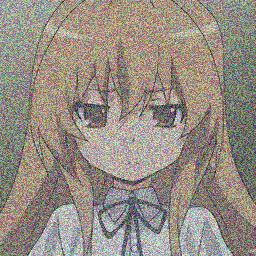

In [7]:
noise = 256*np.random.rand(*img.size, 3)
noisy_img = ((img + noise)/2).astype(np.uint8)
Image.fromarray(noisy_img)

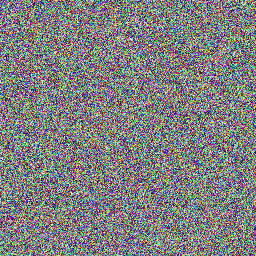

In [8]:
Image.fromarray(noise.astype(np.uint8))

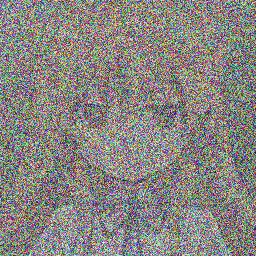

In [9]:
more_noisy_img = ((img + 4*noise)/5).astype(np.uint8)
Image.fromarray(more_noisy_img)

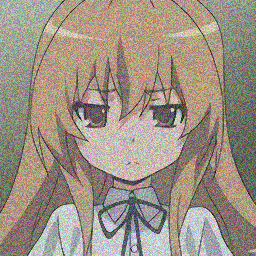

In [10]:
less_noisy_img = ((img + 0.5*noise)/1.5).astype(np.uint8)
Image.fromarray(less_noisy_img)

## process dataset

In [11]:
from torchvision import transforms
IMAGE_SIZE = 128
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image) for image in examples["imageB"]]
    return {"images": images}

dataset.set_transform(transform)

Parameter 'transform'=<function transform at 0x7f501e4ca290> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [12]:
import torch
BSIZE = 16
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BSIZE, shuffle=True)

## add noise to dataset

In [13]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

#### demonstrated incremental amount of noise

In [14]:
clean_images = next(iter(train_dataloader))["images"]
# Sample noise to add to the images
noise = torch.randn(clean_images.shape, device=clean_images.device)
bs = clean_images.shape[0]

# Sample a random timestep for each image
timesteps = torch.range(10, 161, 10, dtype=torch.int)

# Add noise to the clean images according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

/var/tmp/ipykernel_3037277/545426060.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  timesteps = torch.range(10, 161, 10, dtype=torch.int)


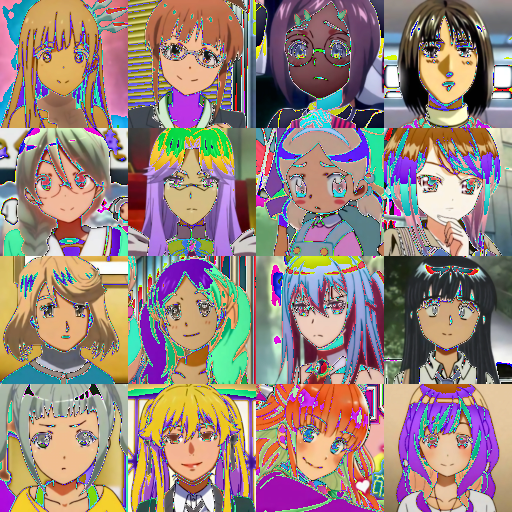

In [15]:
make_image_grid([transforms.ToPILImage()(clean_image) for clean_image in clean_images], rows=4, cols=4)

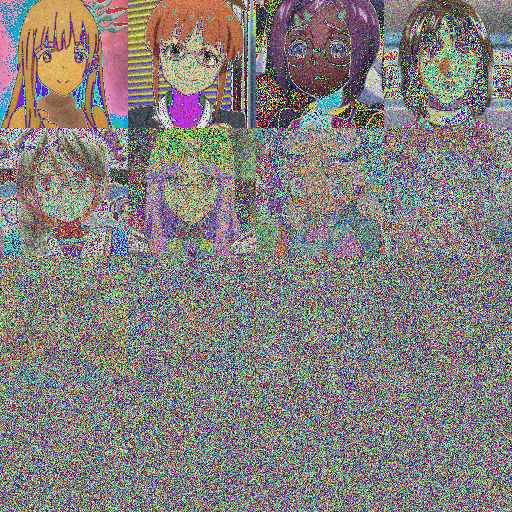

In [16]:
make_image_grid([transforms.ToPILImage()(noisy_image) for noisy_image in noisy_images], rows=4, cols=4)

#### actual noise addition code

In [17]:
clean_images = next(iter(train_dataloader))["images"]
# Sample noise to add to the images
noise = torch.randn(clean_images.shape, device=clean_images.device)
bs = clean_images.shape[0]

# Sample a random timestep for each image
timesteps = torch.randint(
    0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
    dtype=torch.int64
)

# Add noise to the clean images according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

In [18]:
timesteps

tensor([478, 607, 971, 935, 719, 674, 372, 364, 572, 181, 976,   4, 778, 759,
        477, 566])

## UNet model definition

In [19]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [20]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

## UNet model training

#### training setup

In [21]:
from diffusers.optimization import get_cosine_schedule_with_warmup
NUM_EPOCHS = 20
LR = 1e-4
LR_WARMUP_STEPS = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=LR_WARMUP_STEPS,
    num_training_steps=(len(train_dataloader) * NUM_EPOCHS),
)

#### model training loop

In [22]:
import os
from accelerate import Accelerator
MODEL_SAVE_DIR = "anime-128"

# Initialize accelerator and tensorboard logging
accelerator = Accelerator(
    mixed_precision="fp16",
    log_with="tensorboard",
    project_dir=os.path.join(MODEL_SAVE_DIR, "logs"),
)

In [23]:
if accelerator.is_main_process:
    if MODEL_SAVE_DIR is not None:
        os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    accelerator.init_trackers("train_example")

2024-01-04 16:46:26.647430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 16:46:26.647488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 16:46:26.649135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

In [25]:
from tqdm import tqdm
import torch.nn.functional as F
from diffusers import DDPMPipeline

global_step = 0
SAVE_ARTIFACT_EPOCHS = 1
RANDOM_SEED = 42

# Now you train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"]
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape, device=clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
            dtype=torch.int64
        )

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        global_step += 1
        
    # After each epoch you optionally sample some demo images with evaluate() and save the model
    if accelerator.is_main_process:
        pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

        if (epoch + 1) % SAVE_ARTIFACT_EPOCHS == 0 or epoch == NUM_EPOCHS - 1:
            images = pipeline(
                batch_size=BSIZE,
                generator=torch.manual_seed(RANDOM_SEED),
            ).images

            # Make a grid out of the images
            image_grid = make_image_grid(images, rows=4, cols=4)

            # Save the images
            test_dir = os.path.join(MODEL_SAVE_DIR, "samples")
            os.makedirs(test_dir, exist_ok=True)
            image_grid.save(f"{test_dir}/{epoch:04d}.png")

            pipeline.save_pretrained(MODEL_SAVE_DIR)

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:53<00:00,  1.37it/s, loss=0.0688, lr=4.26e-5, step=212]

[2024-01-04 16:49:23,058] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [07:40<00:00,  2.16s/it, loss=0.0688, lr=4.26e-5, step=212]

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:50<00:00,  1.45it/s, loss=0.0195, lr=8.52e-5, step=425]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:50<00:00,  1.46it/s, loss=0.0153, lr=9.97e-5, step=638]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [07:36<00:00,  2.14s/it, loss=0.0153, lr=9.97e-5, step=638]

Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:50<00:00,  1.45it/s, loss=0.0139, lr=9.79e-5, step=851]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:50<00:00,  1.45it/s, loss=0.0116, lr=9.45e-5, step=1064]

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [07:36<00:00,  2.14s/it, loss=0.0116, lr=9.45e-5, step=1064]

Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:50<00:00,  1.46it/s, loss=0.0108, lr=8.98e-5, step=1277]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [02:49<00:00,  1.46it/s, loss=0.00997, lr=8.38e-5, step=1490]

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt

